In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from scipy.signal import find_peaks
import pims
import trackpy as tp
from scipy.interpolate import griddata

from utils.utils import extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0408_074105_019.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps = vid_props[0]

# Scale D-mid
pixel_per_real_width = .75
mpp = 1.333  # microns_per_pixel
print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

# PIMs load in
EXPORT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
extract_frames_from_video(vid_path, vid_filename, frames_filepaths) if EXPORT_FRAMES else None
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder)) 
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

# Save figures
results_path = "./data/results/vortex/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# Time vector
time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
ttrigger = 10  # seconds
time_idx = np.where(time >= ttrigger)[0][0]
ttime = time[:time_idx]
num_frames = time_idx

print("selected time num_frames=", num_frames, "trigger time start-end", np.round(ttime[0]), np.round(ttime[-1]),"\n all frames", frames)

vid properties:  (60, 3311, 1920, 1080)
D MID - FHD, pixel_per_real_width =  0.75
real width (µm):  1440.36 
real height (µm): 810.2
selected time num_frames= 600 trigger time start-end 0.0 10.0 
 all frames (ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0408_074105_019/*.jpg
    Length: 3311 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8


# Z Projection over time

In [3]:
subtract_frame_idx = 0
subtract_frame = frames[subtract_frame_idx]
process_frames = np.arange(subtract_frame_idx + 1, 2400)#num_frames)
# zproj = []
# for nth in process_frames:
#     zproj.append(frames[nth] - subtract_frame)
# zproj = np.stack(zproj)
# zproj = np.min(zproj, axis=0)
SAVE_NPY = False
if SAVE_NPY:
    np.save(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")

pixel_per_real_width = .75
mpp = 1.333  
xy_real_step = 300
xy_px_step = xy_real_step * mpp 

ax_params = {
    "xticks" : np.arange(0,img_width, xy_px_step, dtype=int),
    "xticklabels" : np.arange(0, (img_width / mpp), xy_real_step, dtype=int),
    "yticks" : np.arange(0, img_height, xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
}

-180.20690000000002 85.57499999999999 [-103.800918  -68.9317     -1.9221  ]


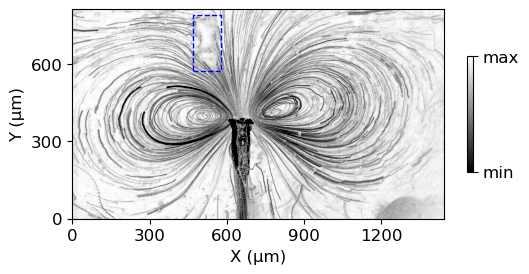

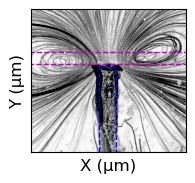

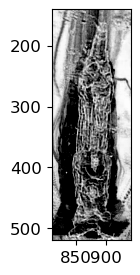

In [10]:
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}
SAVE_FIGURES = False
vmin_ = np.percentile(zproj, 1)#-70 #np.min(zproj)
vmax_ = 0
print(np.min(zproj), np.max(zproj), np.percentile(zproj, [1,5,95]))

# R and D bbox
rotifer_bbox = [835, 910, 150, 510]
detritus_bbox = [625, 770, 760, 1050]
point_count_bbox = [100, img_width-100, 520, 570]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cax = ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
plot_bbox(detritus_bbox, "blue", ax=ax)
ax.set(**ax_params); ax.invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[vmax_, vmin_], yticklabels=["max", "min"])
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-scale_num_process_frames{process_frames[-1]}.jpg", **fig_params) if SAVE_FIGURES else None


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
plot_bbox(rotifer_bbox, "blue", ax=ax)
plot_bbox(point_count_bbox, "m", ax=ax)
ax.set(**ax_params); ax.invert_yaxis();
ax.set(xlim=(550,1200), ylim=(150, 750), xticks=[], yticks=[]);
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-zoomin.jpg", **fig_params) if SAVE_FIGURES else None

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
ax.set(xlim=(810,940), ylim=(140, 520)); ax.invert_yaxis();


# Locate features
- on feature level exclude around rot (tight) and the obsticle

In [ ]:
locate_params = {
    "diameter" : 9,
    "threshold" : 5,
    "invert" : True,
}
frame_nr = 1
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
rotifer_bbox = [835, 910, 150, 510]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]

# Detritus exclude
detritus_bbox = [625, 770, 760, 1050]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# BBoxes to exclude
plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax.set(xlim=(625,770), ylim=(760, 1050));

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax.set(xlim=(800,1000), ylim=(100, 600));


# 2. Batch Process frames

In [ ]:
tp.quiet()
fbatch = tp.batch(frames[:3000], **locate_params)  # :3000 takes ca. 10min

lower_condition = (fbatch.y < 50)
fbatch = fbatch[~lower_condition]

rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
fbatch = fbatch[~rotifer_condition]

detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
fbatch = fbatch[~detritus_condition]

print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))
fbatch


In [ ]:
SAVE_FBATCH = True
fbatch.to_csv(f"{save_figure_path}/fbatch_3000_frames.csv", index=False) if SAVE_FBATCH else None

In [ ]:
# params = ["mass", "size", "ecc", "signal", "raw_mass", "ep"]

# fig, ax = plt.subplots(1, 6, figsize=(19,2.5))
# for nth, param in enumerate(params):
#     ax[nth].hist(fbatch[param], bins=100)
#     ax[nth].set(xlabel=param, ylabel='count');

# 3. Link particles / frames to trajectories

In [ ]:
link_params = {
    "search_range" : 40,  # within ± N pixels
    "memory" : 3,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/2); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

In [ ]:
SAVE_TRAJS = False
LOAD_TRAJS = True
trajs.to_csv(f"{save_figure_path}/trajs_3000_frames.csv", index=False) if SAVE_TRAJS else None
trajs = pd.read_csv(f"{save_figure_path}/trajs_3000_frames.csv") if LOAD_TRAJS else None

# 4. Visualize Trajectories

In [ ]:
fig, ax = plt.subplots()
tp.plot_traj(trajs, superimpose=frames[time_idx], label=False, ax=ax); #ax.set(**ax_params); 

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : 1, "alpha" : .1, "color" : "k"});
ax.set(**ax_params); ax.invert_yaxis();

### further filtering

In [ ]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std < 15) & (stats.y_std < 15)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

In [ ]:

fig, ax = plt.subplots()
tp.scatter(trajs, ax=ax, plot_style={"ms" : .25, "alpha" : .1, "color" : "r"});
tp.scatter(ctraj, ax=ax, plot_style={"ms" : .5, "alpha" : .1, "color" : "k"});
plot_bbox(rotifer_bbox, "b")
plot_bbox(detritus_bbox, "b")
ax.invert_yaxis(); 

In [ ]:
df = pd.DataFrame()
particles = ctraj.particle.unique() # all particles
#particles = is_continuous  # only continuous

for nth in particles:
    traj = ctraj.loc[ctraj["particle"] == nth]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df = pd.concat([df, df_loop[1:]])

# XY coordinates
points = df[["x", "y"]].to_numpy()
remain_idx = points[:,1] < 1040 
points = points[remain_idx,:]

# XY Velocity at XY coordinates
velocities = df[["dx", "dy"]].to_numpy()
velocities = velocities[remain_idx,:]

# Velocity per point
v_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp

In [ ]:
# check and remove rapid velocity changes
d_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2)
cx, xbins_ = np.histogram(velocities[:,0], bins=300)
cy, ybins_ = np.histogram(velocities[:,1], bins=300)
cxy, xybins_ = np.histogram(d_xy, bins=300)

fig, ax = plt.subplots(1,3)
ax[0].bar(xbins_[:-1], cx, width=np.diff(xbins_[:2]), color="b")
ax[1].bar(ybins_[:-1], cy, width=np.diff(ybins_[:2]), color="r")
ax[2].bar(xybins_[:-1], cxy, width=np.diff(xybins_[:2]), color="k")
for cax in ax:
    cax.set(ylim=(0, 400))

In [ ]:
SAVE_FIGURES = False
bin_size_2d = 25
sigma_2d = 2

cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 

occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=20)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 95)
ovmax = np.percentile(interpolated_omap, 95)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
plot_bbox(rotifer_bbox, "k", ax=ax[0]); plot_bbox(detritus_bbox, "k", ax=ax[0])
ax[0].set(**ax_params); #ax[0].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
plot_bbox(rotifer_bbox, "k", ax=ax[1]); plot_bbox(detritus_bbox, "k", ax=ax[1])
ax[1].set(**ax_params); #ax[1].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
print("percentiles vmap:", vvmax, "\nomap", ovmax)

In [ ]:
SAVE_FIGURES = True
point_count_bbox = [100, img_width-100, 520, 570]
bbox_condition = (ctraj.y >= 520) & (ctraj.y < 571) & (ctraj.x >= 100) & (ctraj.x < img_width-100)
count, bins = np.histogram(ctraj.loc[bbox_condition,"x"].to_numpy(), bins=np.arange(100, img_width-100, 5))

rotifer_cm_x = 890
bins = (bins - rotifer_cm_x) / mpp
df_counts = pd.DataFrame(np.vstack((bins[:-1], count)).T, columns=["bins", "counts"])

fig, ax = plt.subplots(figsize=(3,1.5))
ax.bar(bins[:-1], count, width=np.diff(bins)[1], color="lightgray")
ax.plot(df_counts.bins, df_counts.counts.rolling(window=3).median(), "-k", lw=1.5)
ax.set(ylim=(0, 800), yticks=[0,250,500,750], xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600],
       xlabel="X (µm)", ylabel="Traj. x-coord. #")
ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-traj-x-coord-histogram.jpg", **fig_params) if SAVE_FIGURES else None

# roll_mean = df_counts.counts.rolling(window=3).median()
# roll_mean = roll_mean - roll_mean.mean()
# plt.figure()
# plt.plot(bins[:-1], roll_mean,"-r")
# peaks = find_peaks(roll_mean)
# bins[peaks[0]]

# plt.plot(bins[peaks[0]], roll_mean[peaks[0]], "ok")
# np.mean(np.diff(bins[peaks[0]]))

In [ ]:
df_filt = pd.DataFrame()

for nth in particles:
    traj = ctraj.loc[ctraj["particle"] == nth]
    traj = traj.loc[bbox_condition]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df_filt = pd.concat([df_filt, df_loop[1:]])

# XY Velocity at XY coordinates
velocities = df_filt[["dx", "dy"]].to_numpy()

# Velocity per point
df_filt["v_xy"] = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp


In [ ]:
bin_width = 20
bin_edges = np.arange(100, img_width-100, bin_width)
df_filt["x_bin"] = pd.cut(df_filt["x"], bins=bin_edges)
grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - rotifer_cm_x) / mpp


fig, ax = plt.subplots(figsize=(3,1.5))
plt.errorbar(bin_centers, medians, yerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=5, capsize=1, zorder=1)
plt.bar(bin_centers, medians, width=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(0, 700), yticks=[0,350,700], xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600],
       xlabel="X (µm)", ylabel="Velocity (µm s$^{-1}$)")

ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-median-velocities-histogram.jpg", **fig_params) if SAVE_FIGURES else None


In [ ]:
full_frames = np.arange(3000)
displacement_array = reindex_calculate_displacement_and_stack(ctraj, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
displacement_array[displacement_array==0.0] = np.nan

fr_time = np.arange(3000) / fps
print(np.nanmin(displacement_array), np.nanmax(displacement_array))

fig, ax = plt.subplots(1, 1, figsize=(3,3))
cax = ax.imshow(displacement_array, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=1, extent=[0, fr_time[-1], displacement_array.shape[0], 0])
ax.set(xlabel="Time (sec)", ylabel="Particle trajectory #")
cbar = fig.colorbar(cax, label="Velocity (mm / sec)", shrink=.5); cbar.ax.set(yticks=(0,1), yticklabels=["0", ">1"]);
ax.spines[["top","right"]].set_visible(False)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-PIV_trajectories-vs-time.jpg", **fig_params) if SAVE_FIGURES else None

In [ ]:
displacement_array = reindex_calculate_displacement_and_stack(ctraj, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)

selected_indices = np.arange(8)
prt_colors = ["k", "slategrey", "b", "teal", "r", "g", "m", "c", "b"]

rwindow=12
fig, ax = plt.subplots(3,1,figsize=(9,9))
for cax in ax:
    for pc, sidx in zip(prt_colors, selected_indices):
        cax.plot(fr_time, df_disp.iloc[:,sidx].rolling(window=rwindow).mean(), lw=1, color=pc, label=f"prt {sidx}");

xylim = {0 : {"ylim" : (0, .3)},
         1 : {"ylim" : (0, .03)},
         2 : {"ylim" : (0, .03), "xlim" : (0, 10)}}

for nth, cax in enumerate(ax):
    cax.set(xlabel="Time (sec)", ylabel="Velocity (mm/sec)", **xylim[nth])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-velocity-vs-time.jpg", **fig_params) if SAVE_FIGURES else None

# Velocity field calculation

In [ ]:
# Define grid for velocity field
grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 5), np.arange(0, img_height, 5))

# Interpolate velocities onto grid
grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)

print(np.nanmin(omega), np.nanmax(omega))

In [ ]:
vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=3)

plt.figure()
plt.imshow(vort_map, vmin=-.5,vmax=.5, cmap="PuOr", alpha=1)

In [ ]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v)
plt.gca().invert_yaxis()

In [ ]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

print(len(is_continuous))

fig, ax = plt.subplots(1,1)
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        tp.plot_traj(traj, ax=ax, plot_style={"lw" : 1, "alpha" : .6, "color" : "k"})

In [ ]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[frame_nr], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 20)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

#ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

### trajectory params

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");